In [1]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu 
import numpy as np
from skimage.segmentation import clear_border
from skimage.morphology import binary_dilation, binary_closing, square

# convert the image to gray
img = rgb2gray(imread("resources/page361.jpg"))

#binarize the image
for_edge_detection_img = np.ones(img.shape)
r,c = img.shape
divider = 2
for ri in range(divider):
    for ci in range(divider):
        region = img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)]
        thresh = threshold_otsu(region)
        for_edge_detection_img[int((ri/divider)*r):int((ri/divider+1/divider)*r), int((ci/divider)*c):int((ci/divider+1/divider)*c)] = region < thresh

plt.imshow(for_edge_detection_img)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
from skimage.color import label2rgb
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

# label image regions
label_image = label(for_edge_detection_img)
al_areas = []
for region in regionprops(label_image):
    al_areas.append(region.area)

In [3]:
import math
math.floor(math.sqrt(np.median(al_areas)))

10

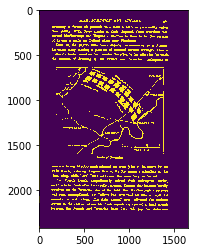

In [4]:
plt.imshow(binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas))))))
plt.show()

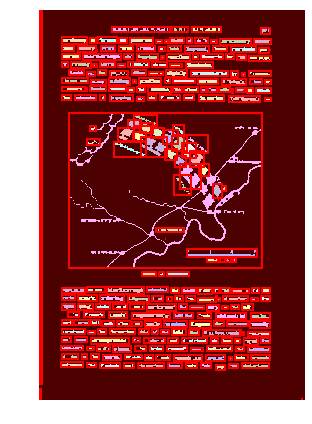

In [5]:
binary_closed = binary_closing(for_edge_detection_img, square(math.floor(math.sqrt(np.median(al_areas)))))
# label image regions
label_image = label(binary_closed)
image_label_overlay = label2rgb(label_image, image=binary_closed)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()